# loading modules

In [1]:
%load_ext autoreload
%autoreload 2
from model import scVI_final as scVI
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import pickle
from benchmarking import *
import numpy as np
import scipy.stats as stats
from helper import *
import time
from IDR import IDR
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# parameters

In [2]:
learning_rate = 0.0004
epsilon = 0.01

# import data

In [3]:
# expression data
data_path = "/home/romain/scVI/data/10xPBMCs/"
expression_train = np.load(data_path + "de/data_train.npy")
expression_test = np.load(data_path + "de/data_test.npy")

# qc metrics
r_train = np.load(data_path + "design_train.npy")
r_test = np.load(data_path + "design_test.npy")
qc_train = np.load(data_path + "qc_train.npy")
qc_test = np.load(data_path + "qc_test.npy")

# labels
c_train = np.loadtxt(data_path + "label_train")
c_test = np.loadtxt(data_path + "label_test")

# batch info
b_train = np.loadtxt(data_path + "b_train")
b_test = np.loadtxt(data_path + "b_test")

# corrupted data
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
        np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")
        
#gene info
micro_array_result = pd.read_csv(data_path+"de/gene_info.csv")
gene_names = micro_array_result["ENSG"]
gene_symbols = micro_array_result["GS"]
cd_p_value = micro_array_result["CD_P.Value"]
bdc_p_value = micro_array_result["BDC_P.Value"]
bdc2_p_value = micro_array_result["BDC2_P.Value"]

In [4]:
expression_train.shape, expression_test.shape

((9029, 3346), (3010, 3346))

# Computational graph

In [5]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

# getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                          optimize_algo=optimizer, phase=training_phase, \
                           library_size_mean=mean, library_size_var=var, n_latent=10)

# Session creation
sess = tf.Session()

Running scVI on 3346 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


Model saved in path: /tmp/10xPBMCs_DE_125_ep.ckpt


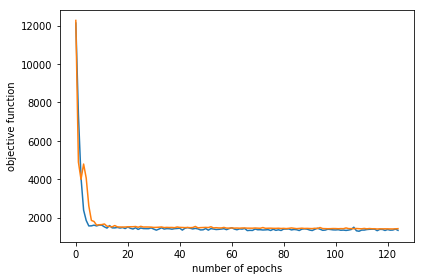

In [6]:
# start a new graph and fit the training set
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
result = train_model(model, (expression_train, expression_test), sess, 125)
save_path = saver.save(sess, "/tmp/10xPBMCs_DE_125_ep.ckpt")
print("Model saved in path: %s" % save_path)
plot_training_info(result)
#saver.restore(sess, "/tmp/10xPBMCs_DE_125_ep.ckpt")

# Evaluation methods

### DE

In [7]:
def sample_posterior(model, X, M_z):
    # shape and simulation
    results = {}
    ind = np.arange(X.shape[0])

    # repeat the data for sampling
    X_m = np.repeat(X, M_z, axis=0)
    ind = np.repeat(ind, M_z, axis=0)
        
    #NN part
    dic_x = {expression: X_m, training_phase:False, kl_scalar:1.} 
    z_m, l_m = sess.run((model.z, model.library), feed_dict=dic_x)
    dic_z = {model.z: z_m, model.library:l_m, training_phase:False, kl_scalar:1.}
    rate, dropout, scale = sess.run((model.px_rate, model.px_dropout, model.px_scale), feed_dict=dic_z)
    dispersion = np.tile(sess.run((tf.exp(model.px_r))), (rate.shape[0], 1))
    
    results["library"] = l_m
    results["mean"] = rate
    results["latent"] = z_m
    results["dispersion"] = dispersion
    results["dropout"] = dropout
    results["sample_rate"] = scale
    results["index"] = ind
    return results

In [8]:
def get_sampling(model, subset_a, subset_b, M_z):
    #get q(z| xa) and q(z| xb) and sample M times from it, then output gamma parametrizations
    res_a = sample_posterior(model, expression_train[subset_a], M_z)
    res_b = sample_posterior(model, expression_train[subset_b], M_z)
    return res_a, res_b

In [9]:
def get_statistics(res_a, res_b, M_p=10000, permutation=False):
    """
    Output average over statistics in a symmetric way (a against b)
    forget the sets if permutation is True
    """
    
    #agregate dataset
    samples = np.vstack((res_a["sample_rate"], res_b["sample_rate"]))
    
    # prepare the pairs for sampling
    list_1 = list(np.arange(res_a["sample_rate"].shape[0]))
    list_2 = list(res_a["sample_rate"].shape[0] + np.arange(res_b["sample_rate"].shape[0]))
    if not permutation:
        #case1: no permutation, sample from A and then from B
        u, v = np.random.choice(list_1, size=M_p), np.random.choice(list_2, size=M_p)
    else:
        #case2: permutation, sample from A+B twice
        u, v = (np.random.choice(list_1+list_2, size=M_p), \
                    np.random.choice(list_1+list_2, size=M_p))
    
    # then constitutes the pairs
    first_set = samples[u]
    second_set = samples[v]
    
    res = np.mean(first_set >= second_set, 0)
    res = np.log(res) - np.log(1-res)
    return res

In [139]:
interest = "CD"
couple_celltypes = (3, 2)
rank_auc = 111
p_prior = 0.03

# interest = "BDC"
# couple_celltypes = (4, 0)
# rank_auc = 800
# p_prior = 0.25

In [140]:
# getting p_values
p_value = micro_array_result[interest + "_adj.P.Val"]
signed_p_value = - np.log10(p_value) * np.sign(micro_array_result[interest + "_logFC"])
# setting up parameters
A, B, M_z = 100, 100, 200
set_a = np.where(c_train == couple_celltypes[0])[0]
set_b = np.where(c_train == couple_celltypes[1])[0]

# subsampling cells and computing statistics
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_b, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=40000)

CD
Detected  229  genes with scVI
Detected  111  genes with microarray


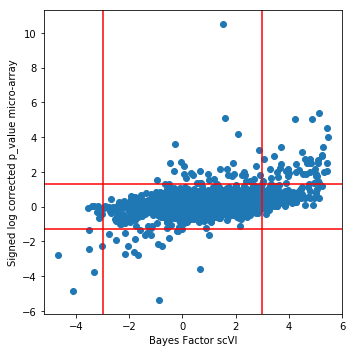

In [141]:
plt.figure(figsize=(5, 5))
plt.scatter(st, signed_p_value)
plt.axvline(x=3, c="r")
plt.axvline(x=-3, c="r")
plt.axhline(y=np.log10(0.05), c="r")
plt.axhline(y=-np.log10(0.05), c="r")
plt.xlabel("Bayes Factor scVI")
plt.ylabel("Signed log corrected p_value micro-array")
plt.tight_layout()
#plt.savefig(interest + "_Bayes_factor_vs_micro_array.pdf", dpi=300)
print interest
print "Detected ", np.sum(2 * np.abs(st) >= 6), " genes with scVI"
print "Detected ", np.sum(p_value <= 0.05), " genes with microarray"

In [156]:
matched_genes = [x[0] for x in pd.read_csv(data_path + "gene_data/" + link + "_DN.txt").iloc[1:].values \
                 if x[0] in gene_symbols.values]
print len(matched_genes)

47


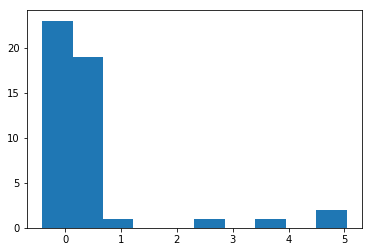

(array([  2.,   2.,  11.,   6.,  10.,  11.,   2.,   0.,   1.,   2.]),
 array([-1.89720624, -1.16358474, -0.42996324,  0.30365826,  1.03727976,
         1.77090126,  2.50452276,  3.23814426,  3.97176576,  4.70538726,
         5.43900876]),
 <a list of 10 Patch objects>)

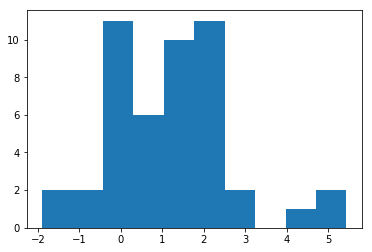

In [157]:
plt.hist([signed_p_value[gene_symbols == t].values[0] for t in matched_genes])
plt.show()
plt.hist([st[gene_symbols == t][0] for t in matched_genes if np.isfinite(st[gene_symbols == t][0])])

In [166]:
bayes_factor = st

if interest == "CD":
    link = "GSE8835_CD4_VS_CD8_TCELL"
    #link = "GSE27786_CD4_VS_CD8_TCELL" # MOUSE
else:
    link = "GSE29618_BCELL_VS_MDC"
    
down = gene_symbols[np.where(bayes_factor >= 3)[0]].values
up = gene_symbols[np.where(bayes_factor <= -3)[0]].values

print len(down), "down regu genes"
print len(up), "up regu genes\n"

    
print link
print "up\n"
list_gene = [x[0] for x in \
                     pd.read_csv(data_path + "gene_data/" + link + "_UP.txt").iloc[1:].values
                    if len(np.where(up == x[0])[0]) > 0]
for (x, y, z) in zip(list_gene, [bayes_factor[gene_symbols == t][0] for t in list_gene], [signed_p_value[gene_symbols == t].values[0] for t in list_gene]):
    print x, "\t", y, "\t", z

print "\n\ndown\n"
list_gene = [x[0] for x in \
                     pd.read_csv(data_path + "gene_data/" + link + "_DN.txt").iloc[1:].values
                    if len(np.where(down == x[0])[0]) > 0]
for (x, y, z) in zip(list_gene, [bayes_factor[gene_symbols == t][0] for t in list_gene], [signed_p_value[gene_symbols == t].values[0] for t in list_gene]):
    print x, "\t", y, "\t", z
    
    
if interest == "CD":
    print "\n\n\nManual match with p-values"
    for (x, y, z) in zip(up, [bayes_factor[gene_symbols == t][0] for t in up], [signed_p_value[gene_symbols == t].values[0] for t in up]):
        print x, "\t", y, "\t", z    

215 down regu genes
14 up regu genes

GSE8835_CD4_VS_CD8_TCELL
up



down

PHF21A 	3.43481333077 	0.496651096617



Manual match with p-values
ID3 	-3.20976225723 	-0.297756228411
AK5 	-3.53709482062 	-0.0909007887638
MAL 	-4.68205553549 	-2.80055056252
PDK1 	-3.00223512006 	-2.2894008986
FHIT 	-3.31604010204 	-3.78583386603
ANKRD55 	-4.10955339674 	-4.88373982183
SERINC5 	-3.52353341332 	-1.33325700172
EPHB6 	-3.13779228708 	-0.672098119585
RPL39 	-3.17091585603 	0.0359611459536
EPHX2 	-3.50130930551 	-2.45061948196
RPL30 	-3.39586321108 	0.0147643156419
RPS25 	-3.02917753325 	-0.064575347829
TSHZ2 	-3.33243757117 	0.0154110550894
CBR3 	-3.03316223217 	-0.422818054342


In [133]:
# de evaluation param
idr = IDR()

l = []
for i in range(20):
    print i
    subset_a = np.random.choice(set_a, A)
    subset_b = np.random.choice(set_b, B)
    res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
    st = get_statistics(res_a, res_b, M_p=40000)
    res = idr.fit(np.abs(st), -np.log(p_value), p_prior=p_prior)
    auc = auc_score_threshold(p_value, np.abs(st), rank_auc, p_value=False)
    res = list(res)
    res.append([auc])
    l.append([x[0] for x in res])    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [134]:
l

[[0.098108508496392563, 0.76511638981753405, 0.82310038013283759],
 [0.10204886779415501, 0.70559338770095492, 0.82108414442262967],
 [0.11053901515006451, 0.69656060675883413, 0.78205578066474501],
 [0.092319871276983725, 0.75723638566778373, 0.80160268460113904],
 [0.10156801503751359, 0.7382247663015209, 0.82806995558154761],
 [0.10206720808484628, 0.70380010211152277, 0.80169319241962211],
 [0.10589606104052082, 0.73693905456759179, 0.81384073408802937],
 [0.10620354898278878, 0.75646847465937639, 0.82342063856747005],
 [0.097921473404904508, 0.75796747476541115, 0.81295514989487172],
 [0.092789054478554761, 0.73459653939862057, 0.81260982775665924],
 [0.088293580578149497, 0.74538494957435986, 0.83092304050572996],
 [0.10187200258874622, 0.7088680537106169, 0.81948842196137406],
 [0.10782533176872471, 0.62747860333644001, 0.81671888271579163],
 [0.098193959043374954, 0.7198167556853412, 0.81551304008800152],
 [0.1058205210091665, 0.73219537986968686, 0.80469526713730732],
 [0.0967

### zinb weight for DESeq2

In [329]:
data = expression_train
# first impute data
dic_x = {expression: data, training_phase:False, kl_scalar:1.} 
z_m, l_m = sess.run((model.z, model.library), feed_dict=dic_x)
dic_z = {model.z: z_m, model.library:l_m, training_phase:False, kl_scalar:1.}
rate, dropout = sess.run((model.px_rate, 1. / (1 + tf.exp(-model.px_dropout))), feed_dict=dic_z)
dispersion = np.tile(sess.run((tf.exp(model.px_r))), (rate.shape[0], 1))
p = rate / (rate + dispersion)
r = dispersion
proba_nb = nbinom.pmf(data, r, p)
weight = (1- dropout) * proba_nb / (dropout * (data == 0) + (1 - dropout) * proba_nb )
weight[np.isnan(weight)] = 1
np.save(data_path + "de/weight_train.npy", weight)

/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


In [339]:
from deseq import *
weight_edge_R_de = Weighted_edgeR(100, 100, \
                 data_path + "de/data_train.npy",\
                 data_path + "label_train", \
                    couple_celltypes, data_path + "de/weight_train.npy")

In [340]:
score = weight_edge_R_de.fit()
print idr.fit(-np.log(p_value), -np.log(score))
print auc_score_threshold(p_value, score, rank_auc, p_value=True)

(array([ 0.09862999]), array([ 0.59959502]))
0.650770708885


### same cluster

In [135]:
# subsampling cells and computing statistics
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_a, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=40000)

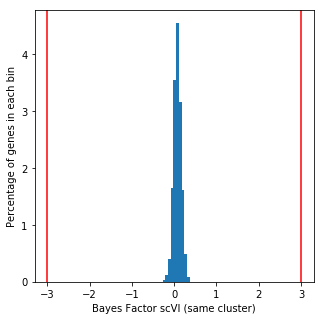

In [136]:
plt.figure(figsize=(5, 5))
plt.hist(st, normed=True)
plt.axvline(x=3, c="r")
plt.axvline(x=-3, c="r")
plt.xlabel("Bayes Factor scVI (same cluster)")
plt.ylabel("Percentage of genes in each bin")
plt.savefig("null_Bayes_factor.pdf", dpi=300)

# GENE VARIANCE B VS DC

In [33]:
interest = "BDC"
couple_celltypes = (4, 0)

#Bayes Factor sampling
A, B, M_z = 100, 100, 300
set_a = np.where(c_train == couple_celltypes[0])[0]
set_b = np.where(c_train == couple_celltypes[1])[0]
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_b, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=40000)


# Histogram sampling
indices = np.hstack([np.where(c_train == couple_celltypes[0])[0][:1000],\
        np.where(c_train == couple_celltypes[1])[0][:1000]])
level_0 = len(np.where(c_train == couple_celltypes[0])[0][:1000])
level_1 = len(np.where(c_train == couple_celltypes[1])[0][:1000])
data = expression_train[indices]
qc = qc_train[indices]
r = r_train[indices]
results = sample_posterior(model, data, 10)

/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


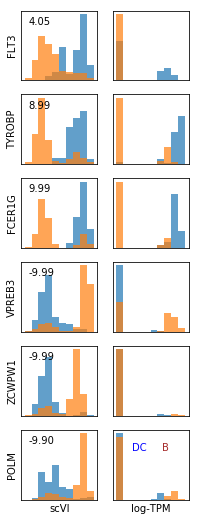

In [35]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(3, 9))
gs = gridspec.GridSpec(6, 2)
fw_scVI = results["mean"] / np.exp(results["library"])
fw_UMI = data / np.sum(data.astype(np.float), axis=1)[:, np.newaxis]
gene_interest_BDC = ['FLT3', 'TYROBP', 'FCER1G', 'VPREB3', 'ZCWPW1', 'POLM'] 
for i in range(6):
    # four different genes
    # scVI vs UMIs
    ax = plt.subplot(gs[i, 0])
    _, bins = np.histogram(np.log(fw_scVI[:, gene_symbols == gene_interest_BDC[i]]))
    ax.hist(np.log(fw_scVI[:level_0, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.hist(np.log(fw_scVI[level_0:, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    
    bf = st[gene_symbols == gene_interest_BDC[i]][0]
    if not np.isfinite(bf):
        bf = np.sign(bf) * 9.99
    ax.text(0.1, 0.8, '{:.2f}'.format(bf), transform=ax.transAxes)

    ax.set_ylabel(gene_interest_BDC[i])
    ax = plt.subplot(gs[i, 1])
    _, bins = np.histogram(np.log(1 + 1e6 * fw_UMI[:, gene_symbols == gene_interest_BDC[i]]))
    ax.hist(np.log(1 + 1e6 * fw_UMI[:level_0, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.hist(np.log(1 + 1e6 * fw_UMI[level_0:, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    if i == 5:
        ax.text(0.25, 0.7,'DC', color="b", transform=ax.transAxes)
        ax.text(0.65, 0.7,'B', color="brown", transform=ax.transAxes)

plt.subplot(gs[-1, 1]).set_xlabel("log-TPM")
plt.subplot(gs[-1, 0]).set_xlabel("scVI")
plt.savefig("genes_regu_BDC.pdf", dpi=300)
plt.show()

In [ ]:
# NOW BAYES FACTOR
import matplotlib.gridspec as gridspec
plt.figure(figsize=(3, 9))
gs = gridspec.GridSpec(6, 2)
gene_interest_BDC = ['FLT3', 'TYROBP', 'FCER1G', 'VPREB3', 'ZCWPW1', 'POLM'] 
for i in range(6):
    # four different genes
    # scVI vs UMIs
    ax = plt.subplot(gs[i, 0])
    im = bayes_factor(np.where(gene_symbols == gene_interest_BDC[i])[0])
    ax.imshow(im, cmap='bwr', interpolation='nearest')
    ax.axis("off")
    ax.set_ylabel(gene_interest_BDC[i])

    ax = plt.subplot(gs[i, 1])
    im = TPM_dis(np.where(gene_symbols == gene_interest_BDC[i])[0])
    ax.imshow(im, cmap='bwr', interpolation='nearest')
    ax.axis("off")
    
plt.subplot(gs[-1, 1]).set_xlabel("log-TPM")
plt.subplot(gs[-1, 0]).set_xlabel("scVI")
plt.savefig("bf_genes_regu_BDC.pdf", dpi=300)
plt.show()

# GENE VARIANCE CD4 CD8

In [74]:
interest = "CD"
couple_celltypes = (3, 2)

# Bayes Factor Sampling
A, B, M_z = 1000, 1000, 30
set_a = np.where(c_train == couple_celltypes[0])[0]
set_b = np.where(c_train == couple_celltypes[1])[0]
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_b, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=40000)

# Histograms sampling
indices = np.hstack([subset_a, subset_b])
level_0 = len(subset_a)
data = expression_train[indices]
qc = qc_train[indices]
r = r_train[indices]
results = sample_posterior(model, data, 30)

In [75]:
interesting_genes = ['DCPS', 'ITGB2', 'RGS2', 'SH3GLB2', 'SLC10A3']
zip(interesting_genes, [st[gene_symbols == t][0] for t in interesting_genes])

[('DCPS', 3.1160510262552124),
 ('ITGB2', 2.9256512435799706),
 ('RGS2', 3.3722209267790086),
 ('SH3GLB2', 2.7046419541135651),
 ('SLC10A3', 3.5874059373651406)]

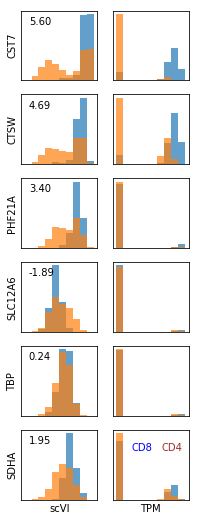

In [76]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(3, 9))
gs = gridspec.GridSpec(6, 2)
fw_scVI = results["mean"] / np.exp(results["library"])
fw_UMI = 1.0 * data / np.sum(data, axis=1)[:, np.newaxis]
gene_interest_BDC = ['CST7', 'CTSW', 'PHF21A', 'SLC12A6', 'TBP', "SDHA"] 
for i in range(6):
    # four different genes
    # scVI vs UMIs
    ax = plt.subplot(gs[i, 0])
    _, bins = np.histogram(np.log(fw_scVI[:, gene_symbols == gene_interest_BDC[i]]))
    ax.hist(np.log(fw_scVI[:level_0, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.hist(np.log(fw_scVI[level_0:, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    ax.text(0.1, 0.8, '{:.2f}'.format(st[gene_symbols == gene_interest_BDC[i]][0]), transform=ax.transAxes)
    ax.set_ylabel(gene_interest_BDC[i])
    ax = plt.subplot(gs[i, 1])
    _, bins = np.histogram(np.log(1 + 1e6 * fw_UMI[:, gene_symbols == gene_interest_BDC[i]]))
    ax.hist(np.log(1 + 1e6 * fw_UMI[:level_0, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.hist(np.log(1 + 1e6 * fw_UMI[level_0:, gene_symbols == gene_interest_BDC[i]]), bins=bins, normed=True, alpha=0.7)
    ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    if i == 5:
        ax.text(0.25, 0.7,'CD8', color="b", transform=ax.transAxes)
        ax.text(0.65, 0.7,'CD4', color="brown", transform=ax.transAxes)
        
plt.subplot(gs[-1, 1]).set_xlabel("TPM")
plt.subplot(gs[-1, 0]).set_xlabel("scVI")
plt.savefig("genes_regu_CD.pdf", dpi=300)
plt.show()

In [215]:
def bayes_factor(gene):
    h = 2
    ratio = 0.5 * np.ones(shape=(A + B + h , A + B + h))
    # is gene g more in set a than in set a
    def update_log(subset_left, subset_right, offset_left, offset_right):     
        res_a, res_b = get_sampling(model, subset_left, subset_right, M_z)
        for i in range(A):
            for j in range(A):
                i_a = res_a["sample_rate"][res_a["index"] == i, gene]
                i_b = res_b["sample_rate"][res_b["index"] == j, gene]
                p = np.mean(i_a > i_b)
                ratio[i+ offset_left, j+ offset_right] = p 

    update_log(subset_a, subset_a, 0, 0)
    update_log(subset_a, subset_b, 0, A + h)
    update_log(subset_b, subset_a, A + h, 0)
    update_log(subset_b, subset_b, A + h, A + h)
    ratio[ratio == 1] = np.max(ratio[ratio < 1])
    ratio[ratio == 0] = np.min(ratio[ratio > 0]) 
    im = np.log(ratio / (1 - ratio))
    return im

def TPM_dis(gene):
    h = 2
    ratio = np.zeros(shape=(A + B + h , A + B + h))
    # is gene g more in set a than in set a

    norm_umi = np.copy(expression_train)
    norm_umi /= np.sum(norm_umi, axis=1)[:, np.newaxis]
    norm_umi = np.log(1 + 1e6 * norm_umi)
    expression_subset_a = norm_umi[subset_a, gene]
    expression_subset_b = norm_umi[subset_b, gene]
    
    
    def update_log(subset_left, subset_right, offset_left, offset_right):     
        for i in range(A):
            for j in range(A):
                ratio[i+ offset_left, j+ offset_right] = subset_left[i] - subset_right[j]

    update_log(subset_a, subset_a, 0, 0)
    update_log(subset_a, subset_b, 0, A+h)
    update_log(subset_b, subset_a, A+h, 0)
    update_log(subset_b, subset_b, A+h, A+h)
        
    return ratio

# plotting variability

In [7]:
gene_GC = pd.read_csv("/home/romain/scVI/data/10xPBMCs/de/gene_GC.csv", index_col=1).groupby("ensembl_gene_id").max()["percentage_gene_gc_content"]
max_gene_length= pd.read_csv("/home/romain/scVI/data/10xPBMCs/de/gene_GC.csv", index_col=0).groupby("ensembl_gene_id").max()["transcript_length"]
median_gene_length= pd.read_csv("/home/romain/scVI/data/10xPBMCs/de/gene_GC.csv", index_col=0).groupby("ensembl_gene_id").median()["transcript_length"]
# dropout vs cell quality metrics
cell_qc = pd.read_csv(data_path + "full_qc.csv", index_col=0).columns.values

In [8]:
def sample_posterior(X):
    # shape and simulation
    results = {}

    dic_x = {expression: X, training_phase:False, kl_scalar:1.} 
    z_m, l_m = sess.run((model.z, model.library), feed_dict=dic_x)
    dic_z = {model.z: z_m, model.library:l_m, training_phase:False, kl_scalar:1.}
    rate, dropout = sess.run((model.px_rate, model.px_dropout), feed_dict=dic_z)
    
    dispersion = np.tile(sess.run((tf.exp(model.px_r))), (rate.shape[0], 1))
    
    results["library"] = l_m
    results["mean"] = rate
    results["latent"] = z_m
    results["dispersion"] = dispersion
    results["dropout"] = dropout
    return results

In [9]:
def process_proba(logit_dropout, mean=None, dispersion=None, logits=False, agg=None):
    
    p = 1 / (1 + np.exp(- logit_dropout))
    if mean is not None:
        p = (1-p) / scipy.special.gamma(dispersion) * np.power(dispersion / (dispersion + mean), dispersion) 
        
    p[p > 1] = np.max(p[p < 1])
    p[p == 0] = np.min(p[p > 0])

    return p

In [10]:
def normalize_plot(x, y, z, s="", logit=True, normalize=True, plot=True):
    """
    plot to verify that x and y is correlated with z
    """
    
    if logit:
        # take logits before averaging
        x = np.log(x / (1-x))
        y = np.log(y / (1-y))
        
    # test shapes
    if z.shape[0] == x.shape[0]:
        #average across genes
        x = np.mean(x, axis=1)
        y = np.mean(y, axis=1)
    
    elif z.shape[0] == x.shape[1]:
        # we got a gene problem, ave ac. cells
        x = np.mean(x, axis=0)
        y = np.mean(y, axis=0)
    
    else: 
        print "Wrong shapes !"
    
    if normalize:
        # normalization workflow
        x = x - np.mean(x)
        x /= np.std(x)
        y = y - np.mean(y)
        y /= np.std(y)
        z = z - np.mean(z)
        z /= np.std(z)
    
    if plot:
        # scattering workflow
        f, axarr = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
        axarr[0].scatter(x, z, alpha=0.5)
        axarr[1].scatter(y, z, alpha=0.5)
    
    if normalize:
        if plot:
            axarr[0].axis((-3,3,-3,3))
            axarr[1].axis((-3,3,-3,3))   
        # regression workflow
        a_x, intercept, r_value_x, p_value_x, std_err = stats.linregress(x,z)
        
        if plot:
            l = np.linspace(-3, 3)
            axarr[0].plot(l, a_x * l, color='black')
            supp = "a={0:.2f} \np={1:.1e}".format(a_x, p_value_x)
            if a_x >0.1:
                axarr[0].text(1, -2.2, supp, fontsize=12)
            else:
                axarr[0].text(1, 2.2, supp, fontsize=12) 
            
            
        a_y, intercept, r_value_y, p_value_y, std_err = stats.linregress(y,z)
        
        if plot:
            supp = "a={0:.2f} \np={1:.1e}".format(a_y, p_value_y)
            l = np.linspace(-3, 3)
            axarr[1].plot(l, a_y * l, color='black')
            if a_y >0.1:
                axarr[1].text(1, -2.2, supp, fontsize=12)
            else:
                axarr[1].text(1, 2.2, supp, fontsize=12) 
      
    if plot:
        axarr[0].set_xlabel("Bernouilli zero prob")
        axarr[1].set_xlabel("NB zero prob")
        axarr[0].set_ylabel(s)

    return a_x, r_value_x, a_y, r_value_y

 Let us retrain several times now and see aggregated statistics

In [80]:
list_plots = ["probs_VS_emp_gene_detection", "probs_VS_emp_lib_size", \
              "probs_VS_G_length", "probs_VS_"+ cell_qc[2], "probs_VS_"+ cell_qc[4], "probs_VS_"+ cell_qc[5]]
trials = 5
list_cell_types = range(0, 8)

res = np.zeros((trials, len(list_cell_types), len(list_plots), 4))

for t in range(trials):
    # train the model for each random seed
    tf.reset_default_graph()
    expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
    kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
    training_phase = tf.placeholder(tf.bool, (), name='training_phase')

    model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                             optimize_algo=optimizer, phase=training_phase, \
                              library_size_mean=mean, library_size_var=var, \
                              n_latent=5)

    # Session creation
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    train_model(100, X_train_aug, r_train_aug, expression_test, r_test, model.train_step)
    # then perform the analysis for each cell type
    for k in list_cell_types:

        indices = np.where(c_train == k)[0]
        data = expression_train[indices]
        qc = qc_train[indices]
        r = r_train[indices]
        results = sample_posterior(data)
        res[t, k, 0] = normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), 
               np.sum(data > 0, axis=1), s="number of gene detected", plot=False)
        res[t, k, 1] = normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), 
               np.log(np.sum(data, axis=1)), s="log average counts per cells",  plot=False)
        res[t, k, 2] = normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), 
               median_gene_length.loc[gene_names].values, s="Gene length (median across isoforms)",  plot=False)
        for i, qc_number in enumerate([2, 4, 5]):
            res[t, k, 3 + i] = normalize_plot(process_proba(results["dropout"]), \
                   process_proba(results["dropout"], results["mean"], results["dispersion"]), \
                   qc[:, qc_number], cell_qc[qc_number], plot=False)

0
Train / Test performance: 15467.7 13993.2
Elapsed Time: 0:00:00
1
Train / Test performance: 4235.08 4151.04
Elapsed Time: 0:00:04
2
Train / Test performance: 1936.02 3775.01
Elapsed Time: 0:00:09
3
Train / Test performance: 1690.1 2069.95
Elapsed Time: 0:00:13
4
Train / Test performance: 1825.09 1702.97
Elapsed Time: 0:00:18
5
Train / Test performance: 1715.92 1629.4
Elapsed Time: 0:00:23
6
Train / Test performance: 1737.83 1706.78
Elapsed Time: 0:00:27
7
Train / Test performance: 1634.58 1708.07
Elapsed Time: 0:00:32
8
Train / Test performance: 1668.26 1512.29
Elapsed Time: 0:00:36
9
Train / Test performance: 1633.56 1458.45
Elapsed Time: 0:00:41
10
Train / Test performance: 1555.33 1707.64
Elapsed Time: 0:00:45
11
Train / Test performance: 1687.15 1541.28
Elapsed Time: 0:00:50
12
Train / Test performance: 1651.17 1718.57
Elapsed Time: 0:00:56
13
Train / Test performance: 1629.76 1429.01
Elapsed Time: 0:01:00
14
Train / Test performance: 1464.18 1571.55
Elapsed Time: 0:01:05
15
Trai

/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract


0
Train / Test performance: 13489.2 11318.7
Elapsed Time: 0:00:00
1
Train / Test performance: 4016.0 4231.98
Elapsed Time: 0:00:04
2
Train / Test performance: 1884.33 3069.14
Elapsed Time: 0:00:10
3
Train / Test performance: 1739.81 2401.78
Elapsed Time: 0:00:15
4
Train / Test performance: 1695.64 1724.08
Elapsed Time: 0:00:19
5
Train / Test performance: 1614.24 1682.6
Elapsed Time: 0:00:24
6
Train / Test performance: 1669.06 1653.06
Elapsed Time: 0:00:29
7
Train / Test performance: 1656.27 1603.14
Elapsed Time: 0:00:36
8
Train / Test performance: 1654.1 1580.51
Elapsed Time: 0:00:41
9
Train / Test performance: 1655.36 1576.48
Elapsed Time: 0:00:45
10
Train / Test performance: 1587.12 1490.77
Elapsed Time: 0:00:50
11
Train / Test performance: 1704.99 1586.58
Elapsed Time: 0:00:55
12
Train / Test performance: 1648.34 1510.48
Elapsed Time: 0:01:00
13
Train / Test performance: 1594.62 1557.75
Elapsed Time: 0:01:05
14
Train / Test performance: 1586.33 1586.43
Elapsed Time: 0:01:10
15
Train

23
Train / Test performance: 1590.32 1580.66
Elapsed Time: 0:02:00
24
Train / Test performance: 1596.99 1505.62
Elapsed Time: 0:02:06
25
Train / Test performance: 1558.08 1510.9
Elapsed Time: 0:02:11
26
Train / Test performance: 1566.23 1542.64
Elapsed Time: 0:02:17
27
Train / Test performance: 1531.44 1444.23
Elapsed Time: 0:02:22
28
Train / Test performance: 1476.65 1491.96
Elapsed Time: 0:02:27
29
Train / Test performance: 1476.62 1445.31
Elapsed Time: 0:02:32
30
Train / Test performance: 1527.45 1454.34
Elapsed Time: 0:02:38
31
Train / Test performance: 1559.11 1503.52
Elapsed Time: 0:02:43
32
Train / Test performance: 1671.7 1509.21
Elapsed Time: 0:02:48
33
Train / Test performance: 1532.06 1500.76
Elapsed Time: 0:02:54
34
Train / Test performance: 1622.35 1470.34
Elapsed Time: 0:02:59
35
Train / Test performance: 1458.91 1455.42
Elapsed Time: 0:03:04
36
Train / Test performance: 1547.42 1506.35
Elapsed Time: 0:03:09
37
Train / Test performance: 1589.15 1593.05
Elapsed Time: 0:03:

46
Train / Test performance: 1485.68 1395.78
Elapsed Time: 0:03:51
47
Train / Test performance: 1479.29 1513.15
Elapsed Time: 0:03:56
48
Train / Test performance: 1501.02 1461.17
Elapsed Time: 0:04:01
49
Train / Test performance: 1527.74 1418.11
Elapsed Time: 0:04:06
50
Train / Test performance: 1471.43 1473.07
Elapsed Time: 0:04:10
51
Train / Test performance: 1523.58 1406.34
Elapsed Time: 0:04:15
52
Train / Test performance: 1513.79 1418.77
Elapsed Time: 0:04:21
53
Train / Test performance: 1459.4 1447.0
Elapsed Time: 0:04:26
54
Train / Test performance: 1479.88 1409.28
Elapsed Time: 0:04:32
55
Train / Test performance: 1442.0 1346.45
Elapsed Time: 0:04:37
56
Train / Test performance: 1494.18 1446.17
Elapsed Time: 0:04:43
57
Train / Test performance: 1431.99 1400.68
Elapsed Time: 0:04:50
58
Train / Test performance: 1418.58 1362.05
Elapsed Time: 0:04:55
59
Train / Test performance: 1507.35 1459.74
Elapsed Time: 0:05:00
60
Train / Test performance: 1480.07 1403.78
Elapsed Time: 0:05:0

69
Train / Test performance: 1451.73 1442.11
Elapsed Time: 0:05:36
70
Train / Test performance: 1484.94 1474.62
Elapsed Time: 0:05:41
71
Train / Test performance: 1497.18 1417.09
Elapsed Time: 0:05:45
72
Train / Test performance: 1486.64 1361.58
Elapsed Time: 0:05:51
73
Train / Test performance: 1449.91 1367.76
Elapsed Time: 0:05:55
74
Train / Test performance: 1510.32 1418.24
Elapsed Time: 0:06:00
75
Train / Test performance: 1454.73 1475.71
Elapsed Time: 0:06:05
76
Train / Test performance: 1494.88 1459.74
Elapsed Time: 0:06:09
77
Train / Test performance: 1482.64 1335.22
Elapsed Time: 0:06:14
78
Train / Test performance: 1459.64 1426.78
Elapsed Time: 0:06:19
79
Train / Test performance: 1458.32 1446.05
Elapsed Time: 0:06:24
80
Train / Test performance: 1499.66 1363.0
Elapsed Time: 0:06:29
81
Train / Test performance: 1468.05 1407.8
Elapsed Time: 0:06:33
82
Train / Test performance: 1425.68 1396.47
Elapsed Time: 0:06:38
83
Train / Test performance: 1533.86 1516.38
Elapsed Time: 0:06:

In [118]:
#np.save("DE_statistics_multi_celltypes.npy", res)

In [11]:
res = np.load("DE_statistics_multi_celltypes.npy")

In [12]:
cell_info =[(0, 'B cells', 1625),
(1, 'CD14+ Monocytes', 2237),
(2, 'CD4 T cells', 5024),
(3, 'CD8 T cells', 1452),
(4, 'Dendritic Cells', 339),
(5, 'FCGR3A+ Monocytes', 351),
(6, 'Megakaryocytes', 88),
(7, 'NK cells', 459),
(8, 'Other', 464)]

In [13]:
list_plots = ["emp_gene_detection", "emp_lib_size", \
              "_G_length",  cell_qc[2], cell_qc[4], cell_qc[5]]

In [14]:
t_stats = np.zeros((5, 8, 6, 2))
p_values = np.zeros_like(t_stats)
# get the t_stats from the regression value
for t in range(5):
    for k in range(8):
        for i in range(6):
            for j in range(2):
                r = res[t, k, i, 2*j +1]
                n = zip(*cell_info)[2][k]
                t_stats[t, k, i, j] = r * np.sqrt((n - 2)/(1 - r**2))
                p_values[t, k, i, j] = 2 * scipy.stats.distributions.t.sf(np.abs(t_stats[t, k, i, j]), n)


In [15]:
# concat p_values across experiments and cell types
p_values = p_values.reshape((40, 6, 2))
t_stats = t_stats.reshape((40, 6, 2))
scores = - np.sign(t_stats) * np.log10(p_values)
#scores = - np.log10(p_values)

/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [16]:
def finite(x):
    return x[np.isfinite(x)]

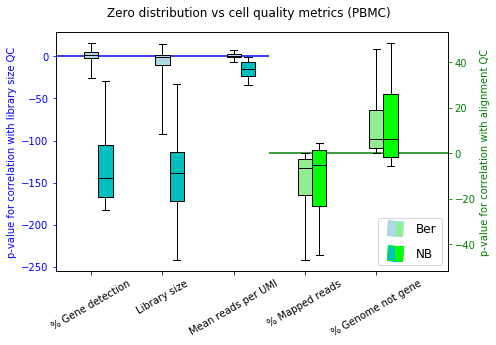

In [28]:
list_plots = ["% Gene detection", "Library size", \
              "_G_length",  "Mean reads per UMI", "% Mapped reads", "% Genome not gene"]

data_1 = [finite(scores[:, i, 0]) for i in [0, 1, 3]]
data_1b = [finite(scores[:, i, 1]) for i in [0, 1, 3]]

props = dict(widths=0.2,patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

bp1 = ax1.boxplot(data_1, positions=[0, 1, 2], **props)
bp1b = ax1.boxplot(data_1b, positions=[0.2, 1.2, 2.2], **props)
ax1.hlines(y=0, xmin=-0.5, xmax=2.5, color='blue', zorder=1)    
ax1.set_ylabel('p-value for correlation with library size QC', color='b')
ax1.tick_params('y', colors='b')
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
for patch in bp1b['boxes']:
    patch.set_facecolor('c')
    
data_2 = [finite(scores[:, i, 0]) for i in [4, 5]]
data_2b = [finite(scores[:, i, 1]) for i in [4, 5]]
ax2.hlines(y=0, xmin=2.5, xmax=5, color='green', zorder=1)
ax2.set_ylabel('p-value for correlation with alignment QC', color='g')
ax2.tick_params('y', colors='g')
bp2 = ax2.boxplot(data_2, positions=[3, 4], **props)
bp2b = ax2.boxplot(data_2b, positions=[3.2, 4.2], **props)
for patch in bp2['boxes']:
    patch.set_facecolor('lightgreen')
for patch in bp2b['boxes']:
    patch.set_facecolor('lime')

ax1.set_xlim((-0.5, 5))
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xticklabels([list_plots[i] for i in [0, 1, 3, 4, 5]], rotation=30)


m1, = plt.plot([], [], c='lightblue' , marker='s', markersize=15,
              fillstyle='left', linestyle='none')
m2, = plt.plot([], [], c='lightgreen' , marker='s', markersize=15,
              fillstyle='right', linestyle='none')
m3, = plt.plot([], [], c='c' , marker='s', markersize=15,
              fillstyle='left', linestyle='none')
m4, = plt.plot([], [], c='lime' , marker='s', markersize=15,
              fillstyle='right', linestyle='none')

#---- Plot Legend ----



plt.legend(((m2, m1), (m3, m4)), ('Ber',"NB"), numpoints=1, labelspacing=1, fontsize=12, loc="lower right")

fig.suptitle("Zero distribution vs cell quality metrics (PBMC)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("PBMC_zero_qc.pdf", dpi=300)
plt.show()

### Previous "one time" experiment

In [42]:
#indices = np.hstack([np.where(c_train == 2)[0][:1000], np.where(c_train == 3)[0][:1000]])
indices = np.where(c_train == 1)[0]
data = expression_train[indices]
qc = qc_train[indices]
r = r_train[indices]

In [102]:
results = sample_posterior(data)
pickle.dump( results, open( data_path + "de_sampling_info", "wb" ) )

In [321]:
#results = sample_posterior(data)
#pickle.dump( results, open( data_path + "sampling_info", "wb" ) )

In [43]:
results = pickle.load( open( data_path + "sampling_info", "rb" ) )

In [47]:
p_nb = process_proba(results["dropout"], results["mean"], results["dispersion"])
p_zi = process_proba(results["dropout"])
ratio_prob = p_nb / (p_nb + p_zi - p_nb * p_zi )

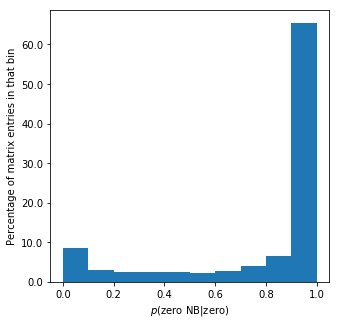

In [66]:
plt.figure(figsize=(5, 5))
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(10 * y)
    return s
    
plt.hist(ratio_prob.flatten(), bins=10, normed=True)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel( r"$p($zero NB$ | $zero$)$")
plt.ylabel("Percentage of matrix entries in that bin")
plt.savefig("pzero_nb.pdf", dpi=300)

#### NON DE PLOTS

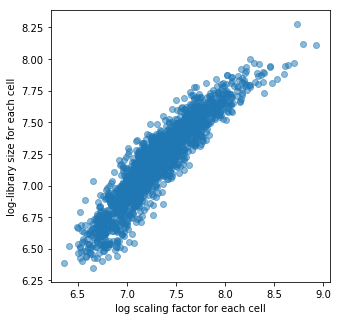

In [14]:
# scaling factor versus log library size across cells
plt.figure(figsize=(5, 5))
plt.scatter(results["library"], np.log(np.sum(data, axis=1)), alpha=0.5)
plt.xlabel('log scaling factor for each cell')
plt.ylabel('log-library size for each cell')
plt.savefig("loglibrary.pdf", dpi=300)
plt.show()

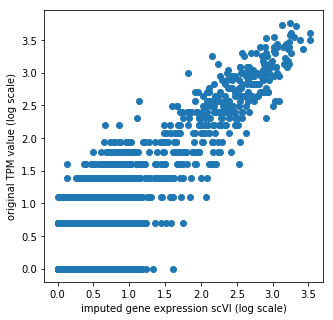

In [24]:
# mean model versus original data
plt.figure(figsize=(5, 5))
plt.scatter(np.log(1 + results["mean"][:100, :210]), np.log(1 + data[:100, :210]))
plt.xlabel('imputed gene expression scVI (log scale)')
plt.ylabel('original TPM value (log scale)')
plt.savefig("reconstruction.pdf", dpi=300)

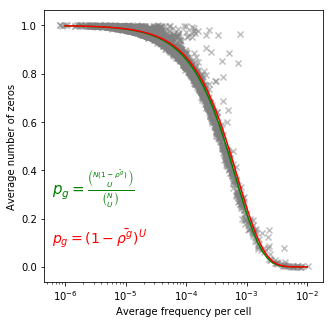

In [89]:
from scipy.stats import hypergeom, binom
# number of molecules against number of zero (points are genes)
scaling = 1
m =  scaling * np.mean(results["mean"] / np.exp(results["library"]), axis=0)
p = np.mean(data == 0, axis=0)

mask = (p > 0) * (m < scaling * 0.03)

m = m[mask]
p = p[mask]

#a, intercept, r_value, p_value, std_err = stats.linregress(1-m,np.log(p))
#linreg = LinearRegression()
#linreg.fit(np.vstack((1-m, (1-m)**2)).T, np.log(p))
#l = np.linspace(0, scaling * 0.01)
#pi_ZIFA = np.exp(linreg.predict(np.vstack((1-l, (1-l)**2)).T))
#pi = np.exp(a * (1-l) + intercept)


c = ["green", "green", "red", "purple"]

plt.figure(figsize=(5, 5))
#plt.plot(l, pi_ZIFA, color=c[0])
#plt.text(0.006, 0.9, r"$p_g = e^{-a\mu^2 -b\mu}$", fontsize=14, color=c[0])

#plt.plot(l, pi, color=c[3])
#plt.text(0.006, 0.6, r"$p_g = e^{-b\mu}$", fontsize=14, color=c[3])

l = np.logspace(-6, -2)

N = 10000
plt.plot(l, [hypergeom.pmf(0, N, N*rho, 1398) for rho in l], color=c[1] )
plt.text(0.0000006, 0.3, r"$p_g = \frac{\binom{N(1-\bar{\rho^g})}{U}}{\binom{N}{U}}$", fontsize=15, color=c[1])

plt.plot(l, [binom.pmf(0, 1398, rho) for rho in l], color=c[2] )
plt.text(0.0000006, 0.1, r"$p_g = (1-\bar{\rho^g})^U$", fontsize=14, color=c[2])

plt.gca().set_xscale("log", nonposx='clip')


plt.xlabel('Average frequency per cell')
plt.ylabel('Average number of zeros')

plt.scatter(m, p, alpha=0.5, color="grey", marker="x")
plt.savefig("fw.pdf", dpi=300)

plt.show()

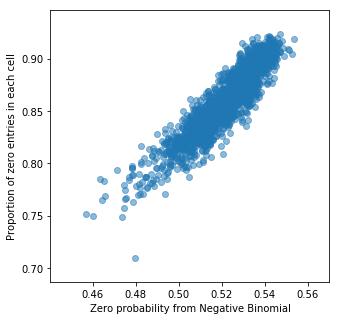

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(np.mean(process_proba(results["dropout"], results["mean"], results["dispersion"]), axis=1),\
        np.mean(data == 0, axis=1), alpha=0.5)
#plt.ylim((0.045, 0.27))
plt.xlabel("Zero probability from Negative Binomial")
plt.ylabel("Proportion of zero entries in each cell")
plt.savefig("unnormalized_zero_NB_genes.pdf", dpi=300)

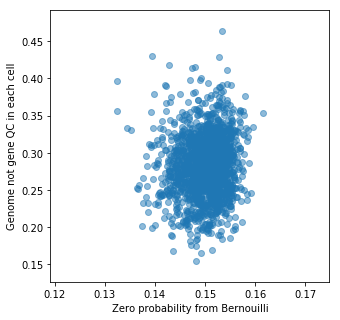

In [64]:
plt.figure(figsize=(5, 5))
plt.scatter(np.mean(process_proba(results["dropout"]), axis=1),\
        qc[:, 5], alpha=0.5)
#plt.ylim((0.045, 0.27))
plt.xlabel("Zero probability from Bernouilli")
plt.ylabel("Genome not gene QC in each cell")
plt.savefig("unnormalized_zero_B_genome.pdf", dpi=300)

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(np.mean(process_proba(results["dropout"]), axis=1),\
        np.mean(data == 0, axis=1))
#plt.ylim((0.045, 0.27))
plt.xlabel("Zero probability from Negative Binomial")
plt.ylabel("Proportion of zero entries in each cell")
#plt.savefig("unnormalized_zero_NB_genes.pdf", dpi=300)

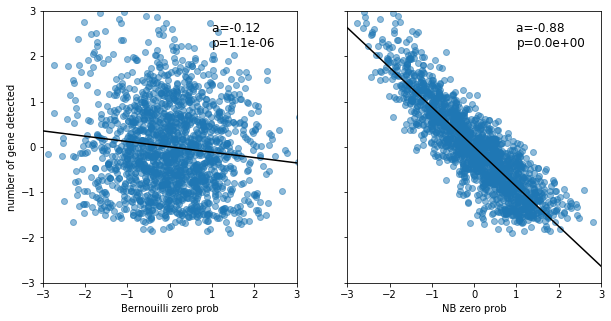

In [40]:
# testing probs correlated to detection rate (points are cells)
normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), 
               np.sum(data > 0, axis=1), s="number of gene detected", logit=True, plot=False)
plt.savefig("probs_VS_emp_gene_detection.pdf", dpi=300)

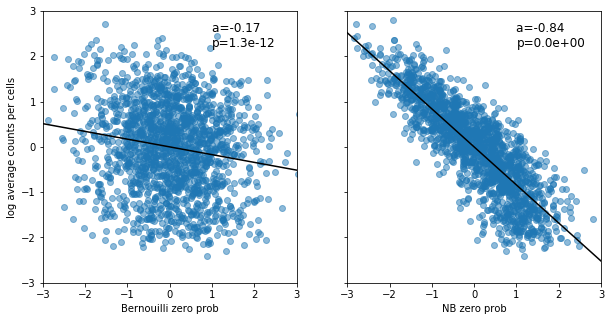

In [180]:
# testing probs correlated to library size (points are cells)
normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), 
               np.log(np.sum(data, axis=1)), s="log average counts per cells")
plt.savefig("probs_VS_emp_lib_size.pdf", dpi=300)

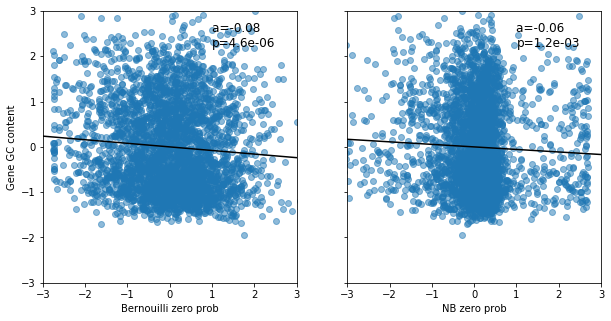

In [181]:
# Dropout vs selection bias AKA gene GC across genes (points are genes)
normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), 
               gene_GC.loc[gene_names].values, s="Gene GC content")
plt.savefig("probs_VS_GC_content.pdf", dpi=300)

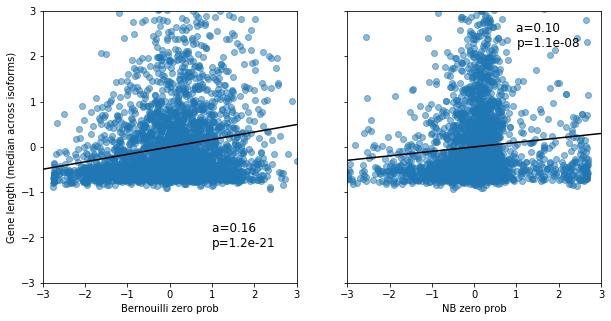

In [182]:
normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), 
               median_gene_length.loc[gene_names].values, s="Gene length (median across isoforms)")
plt.savefig("probs_VS_G_length.pdf", dpi=300)

/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract


(0.097991510354071706, 0.097991507815671022, nan, nan)

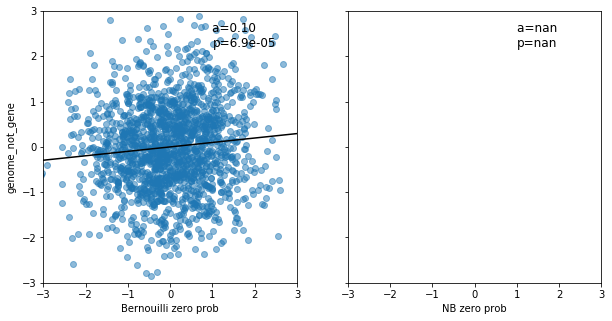

In [60]:
normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), \
               qc[:, 5], cell_qc[5])

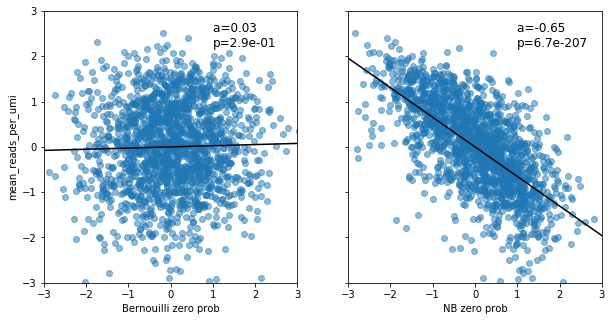

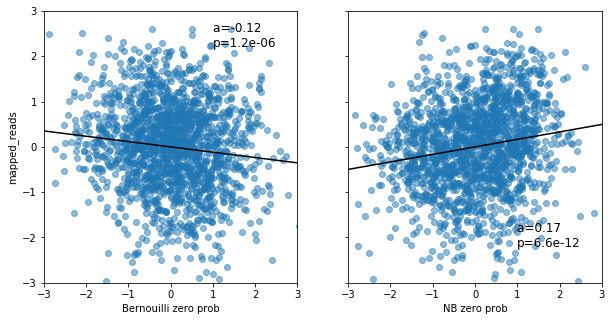

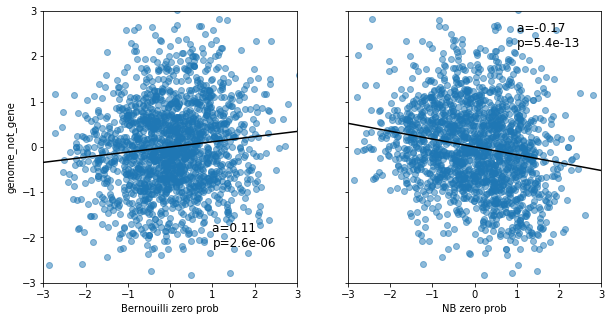

In [186]:
for qc_number in [2, 4, 5]:
    normalize_plot(process_proba(results["dropout"]), \
               process_proba(results["dropout"], results["mean"], results["dispersion"]), \
               qc[:, qc_number], cell_qc[qc_number], logit=True, normalize=True)
    plt.savefig("probs_VS_"+ cell_qc[qc_number] + ".pdf", dpi=300)
    plt.show()

In [ ]:
for qc_pc in range(7):
    normalize_plot(process_proba(results["dropout"]), \
                   process_proba(results["dropout"], results["mean"], results["dispersion"]), \
                   r[:, qc_pc], "QC PC"+str(qc_pc))
    plt.show()

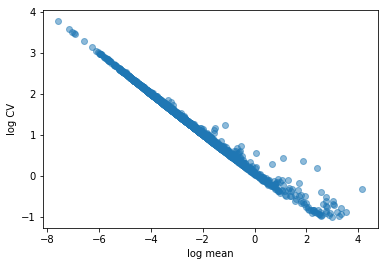

In [66]:
#NB model: plotting log mu versus log CV (points are genes)
m = results["mean"]
v = m + m**2 / results["dispersion"]
plt.scatter(np.mean(np.log(m), axis=0), np.mean(0.5* np.log(v) - np.log(m), axis=0), alpha=0.5)
#ZINB: plotting log mu versus log CV (points are genes)
#m = (1 - process_proba(results["dropout"])) * results["mean"]
#v = m * (1 + results["mean"] * (process_proba(results["dropout"]) + 1 / results["dispersion"]))
#plt.scatter(np.mean(np.log(m), axis=0), np.mean(0.5* np.log(v) - np.log(m), axis=0), alpha=0.5)
plt.xlabel("log mean")
plt.ylabel("log CV")

plt.show()

In [71]:
lin = LinearRegression()
lin.fit(np.mean(np.log(m), axis=0)[:, np.newaxis], np.mean(0.5* np.log(v) - np.log(m), axis=0))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
res = np.abs(lin.predict(np.mean(np.log(m), axis=0)[:, np.newaxis]) - np.mean(0.5* np.log(v) - np.log(m), axis=0))

In [90]:
gene_symbols[res.argsort()[-11:][::-1]]

211     S100A9
822     CXCL10
2937     TUBB1
815        PF4
214     S100A4
981       CD74
2366       FOS
2452     RPLP1
220      RPS27
1086     RPS18
213     S100A6
Name: GS, dtype: object

##### DE PLOTS

In [108]:
fw = results["mean"] / np.exp(results["library"])

In [183]:
a, b = np.argmax(np.var(fw, axis=0)[indices_genes_dn]), np.argmax(np.var(fw, axis=0)[indices_genes_up]) 

In [192]:
a,b = np.random.choice(len(indices_genes_dn), 1)[0], np.random.choice(len(indices_genes_up), 1)[0]

ACP5 MKNK2


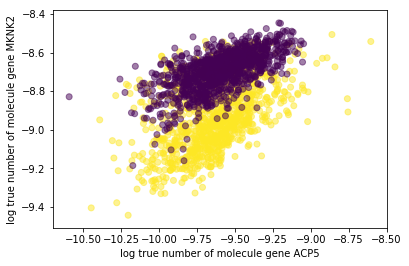

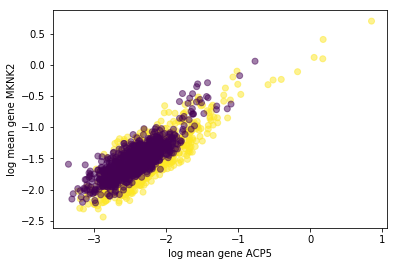

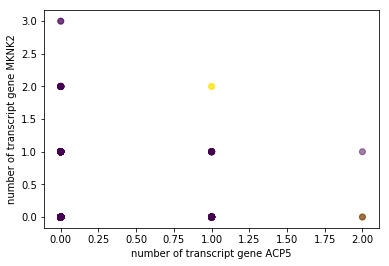

In [197]:
print gene_symbols[indices_genes_dn[a]], gene_symbols[indices_genes_up[b]]
plt.scatter(np.log(fw[:, indices_genes_dn[a]]), np.log(fw[:, indices_genes_up[b]]), c = np.hstack((np.ones(1000), np.zeros(1000))), alpha = 0.5)
plt.xlabel("log true number of molecule gene "+gene_symbols[indices_genes_dn[a]])
plt.ylabel("log true number of molecule gene "+gene_symbols[indices_genes_up[b]])
plt.savefig("de_normalized_genes_fw.pdf", dpi=300)
plt.show()
plt.scatter(np.log(results["mean"][:, indices_genes_dn[a]]), np.log(results["mean"][:, indices_genes_up[b]]), c = np.hstack((np.ones(1000), np.zeros(1000))), alpha = 0.5)
plt.xlabel("log mean gene "+gene_symbols[indices_genes_dn[a]])
plt.ylabel("log mean gene "+gene_symbols[indices_genes_up[b]])
plt.savefig("de_mean_genes_fw.pdf", dpi=300)
plt.show()
plt.scatter(data[:, indices_genes_dn[a]], data[:, indices_genes_up[b]], c = np.hstack((np.ones(1000), np.zeros(1000))), alpha = 0.5)
plt.xlabel("number of transcript gene "+gene_symbols[indices_genes_dn[a]])
plt.ylabel("number of transcript gene "+gene_symbols[indices_genes_up[b]])
plt.savefig("de_counts_genes_fw.pdf", dpi=300)
plt.show()